# **Assignment Team 1**

# **Week 1: Exploratory Data Analysis**

## **Required Figures Checklist**

1. Missingness bar plot (top 15 columns)
2. Missingness-vs-outcome tables for 3 columns
3. Numeric distribution plot (3 variables)

---
## **Project Setup**

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

### Mount Google Drive and Download Dataset

In [2]:
from google.colab import drive
import os
import zipfile
import urllib.request
from pathlib import Path
from sklearn.model_selection import GroupShuffleSplit

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Configuration - Modify PROJECT_ROOT based on your folder structure
PROJECT_ROOT = '/content/drive/MyDrive/AIHC5010_public'
os.makedirs(PROJECT_ROOT, exist_ok=True)
os.makedirs(f'{PROJECT_ROOT}/data/raw', exist_ok=True)
os.makedirs(f'{PROJECT_ROOT}/data/public', exist_ok=True)
os.makedirs(f'{PROJECT_ROOT}/data/private', exist_ok=True)
print(f"Project folder ready: {PROJECT_ROOT}")

Project folder ready: /content/drive/MyDrive/AIHC5010_public


In [4]:
RAW_DIR = Path(f'{PROJECT_ROOT}/data/raw')
ZIP_PATH = RAW_DIR / 'diabetes_130US.zip'

UCI_ZIP_URL = 'https://archive.ics.uci.edu/static/public/296/diabetes+130-us+hospitals+for+years+1999-2008.zip'

def download_dataset():
    """Download and extract the UCI diabetes dataset."""
    csv_path = RAW_DIR / 'diabetic_data.csv'
    if csv_path.exists():
        print(f"Dataset already exists: {csv_path}")
        return csv_path

    print(f"Downloading from UCI...")
    try:
        urllib.request.urlretrieve(UCI_ZIP_URL, ZIP_PATH)
        print(f"Downloaded to: {ZIP_PATH}")
    except Exception as e:
        print(f"Auto-download failed: {e}")
        print("\nManual download instructions:")
        print("1. Go to: https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008")
        print("2. Download the zip file")
        print(f"3. Upload it to: {ZIP_PATH}")
        return None

    print(f"Extracting...")
    with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
        zf.extractall(RAW_DIR)

    for f in RAW_DIR.rglob('diabetic_data.csv'):
        if f.parent != RAW_DIR:
            import shutil
            shutil.move(str(f), str(csv_path))
        print(f"Dataset ready: {csv_path}")
        return csv_path

    print("CSV not found after extraction.")
    return None

raw_csv_path = download_dataset()

Dataset already exists: /content/drive/MyDrive/AIHC5010_public/data/raw/diabetic_data.csv


### Create Train/Dev/Test Splits

**Split Strategy:**
- **Patient-level grouping:** Same patient's encounters stay in same split (prevents data leakage)
- **Label:** `readmit30 = 1` if readmitted within 30 days, else `0`
- **Splits:** Train (64%), Dev (16%), Hidden Test (20%)

In [5]:
SEED = 1337
TEST_SIZE = 0.20
DEV_SIZE = 0.20

def build_label(df):
    """Create binary label: 1 if readmitted within 30 days."""
    return (df['readmitted'].astype(str).str.strip() == '<30').astype(int)

def create_splits(raw_csv, out_public, out_private):
    """Create train/dev/public_test/hidden_test splits with patient-level grouping."""
    print(f"Loading: {raw_csv}")
    df = pd.read_csv(raw_csv)
    print(f"Shape: {df.shape}")

    if 'encounter_id' not in df.columns:
        df.insert(0, 'encounter_id', range(len(df)))

    df['row_id'] = df['encounter_id']
    df['readmit30'] = build_label(df)

    print(f"\nLabel distribution:")
    print(df['readmit30'].value_counts())
    print(f"Positive rate: {df['readmit30'].mean():.2%}")

    feature_df = df.drop(columns=['readmitted'])
    groups = feature_df['patient_nbr'] if 'patient_nbr' in feature_df.columns else feature_df['row_id']
    print(f"\nUnique patients: {groups.nunique():,}")

    # Split 1: Hidden test (20%)
    gss1 = GroupShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=SEED)
    train_dev_idx, hidden_idx = next(gss1.split(feature_df, groups=groups))

    train_dev = feature_df.iloc[train_dev_idx].reset_index(drop=True)
    hidden = feature_df.iloc[hidden_idx].reset_index(drop=True)

    # Split 2: Dev from remaining (20% of 80%)
    groups_td = train_dev['patient_nbr'] if 'patient_nbr' in train_dev.columns else train_dev['row_id']
    gss2 = GroupShuffleSplit(n_splits=1, test_size=DEV_SIZE, random_state=SEED + 1)
    train_idx, dev_idx = next(gss2.split(train_dev, groups=groups_td))

    train = train_dev.iloc[train_idx].reset_index(drop=True)
    dev = train_dev.iloc[dev_idx].reset_index(drop=True)

    public_test = dev.drop(columns=['readmit30']).copy()

    # Save files
    train.to_csv(f'{out_public}/train.csv', index=False)
    dev.to_csv(f'{out_public}/dev.csv', index=False)
    public_test.to_csv(f'{out_public}/public_test.csv', index=False)
    hidden.to_csv(f'{out_private}/hidden_test.csv', index=False)

    print(f"\nSplits created:")
    print(f"  Train:       {len(train):,} rows ({len(train)/len(df):.1%})")
    print(f"  Dev:         {len(dev):,} rows ({len(dev)/len(df):.1%})")
    print(f"  Public Test: {len(public_test):,} rows (unlabeled)")
    print(f"  Hidden Test: {len(hidden):,} rows ({len(hidden)/len(df):.1%})")

    return train, dev, public_test, hidden

if raw_csv_path:
    train, dev, public_test, hidden = create_splits(
        raw_csv=str(raw_csv_path),
        out_public=f'{PROJECT_ROOT}/data/public',
        out_private=f'{PROJECT_ROOT}/data/private'
    )

Loading: /content/drive/MyDrive/AIHC5010_public/data/raw/diabetic_data.csv
Shape: (101766, 50)

Label distribution:
readmit30
0    90409
1    11357
Name: count, dtype: int64
Positive rate: 11.16%

Unique patients: 71,518

Splits created:
  Train:       65,003 rows (63.9%)
  Dev:         16,314 rows (16.0%)
  Public Test: 16,314 rows (unlabeled)
  Hidden Test: 20,449 rows (20.1%)


### Load Existing Splits (if already created)

In [6]:
# Load splits if not already in memory
if 'train' not in dir():
    drive.mount('/content/drive')
    PROJECT_ROOT = '/content/drive/MyDrive/AIHC5010_public'
    train = pd.read_csv(f'{PROJECT_ROOT}/data/public/train.csv')
    dev = pd.read_csv(f'{PROJECT_ROOT}/data/public/dev.csv')
    public_test = pd.read_csv(f'{PROJECT_ROOT}/data/public/public_test.csv')

print(f"Data loaded:")
print(f"  Train: {train.shape}")
print(f"  Dev:   {dev.shape}")
print(f"  Test:  {public_test.shape}")

Data loaded:
  Train: (65003, 51)
  Dev:   (16314, 51)
  Test:  (16314, 50)


---
## **1. Basic Dataset Snapshot**

In [7]:
# Dataset dimensions
rows, cols = train.shape

# Outcome column and readmission rate
outcome_col = 'readmit30'
readmission_rate = train[outcome_col].mean()

# Data types summary
dtype_summary = train.dtypes.map(lambda x: 'Numeric' if x in ['int64', 'float64'] else 'Categorical').value_counts()

# Print summary
print("=" * 50)
print("DATASET SNAPSHOT")
print("=" * 50)
print(f"\nDimensions: {rows:,} rows × {cols} columns")
print(f"\nOutcome Column: {outcome_col}")
print(f"Overall Readmission Rate: {readmission_rate:.2%}")
print(f"\nData Types Summary:")
print(f"  Numeric columns:     {dtype_summary.get('Numeric', 0)}")
print(f"  Categorical columns: {dtype_summary.get('Categorical', 0)}")
print("\n" + "=" * 50)
print("FIRST 5 ROWS")
print("=" * 50)
train.head()

DATASET SNAPSHOT

Dimensions: 65,003 rows × 51 columns

Outcome Column: readmit30
Overall Readmission Rate: 11.16%

Data Types Summary:
  Numeric columns:     15
  Categorical columns: 36

FIRST 5 ROWS


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,row_id,readmit30
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,2278392,0
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,149190,0
2,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,16680,0
3,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,?,?,31,6,16,0,0,0,414,411,250,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,35754,0
4,63768,114882984,Caucasian,Male,[70-80),?,1,1,7,5,?,?,73,0,12,0,0,0,428,492,250,8,NaN,NaN,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,63768,0


---
## **2. Missingness Audit**

### 2.1 Missingness Table

**Important Note:** This dataset uses `'?'` as a placeholder for missing values in several categorical columns. We need to account for both true NaN values and `'?'` markers.

In [8]:
# Create a copy for missingness analysis, treating '?' as missing
df = train.copy()

# Replace '?' with NaN for proper missingness accounting
df_clean = df.replace('?', np.nan)

# Calculate missingness for each column
missing_tbl = pd.DataFrame({
    'missing_count': df_clean.isna().sum(),
    'missing_pct': (df_clean.isna().mean() * 100).round(2)
}).sort_values('missing_pct', ascending=False)

print("=" * 60)
print("MISSINGNESS TABLE (sorted by % missing, descending)")
print("Note: '?' values are treated as missing")
print("=" * 60)
print(f"\nColumns with any missingness:")
display(missing_tbl[missing_tbl['missing_pct'] > 0])

MISSINGNESS TABLE (sorted by % missing, descending)
Note: '?' values are treated as missing

Columns with any missingness:


,missing_count,missing_pct
weight,63018,96.95
max_glu_serum,61584,94.74
A1Cresult,54211,83.40
medical_specialty,31809,48.93
payer_code,25733,39.59
race,1471,2.26
diag_3,904,1.39
diag_2,218,0.34
diag_1,13,0.02


### 2.2 Bar Plot of Top 15 Columns by % Missing

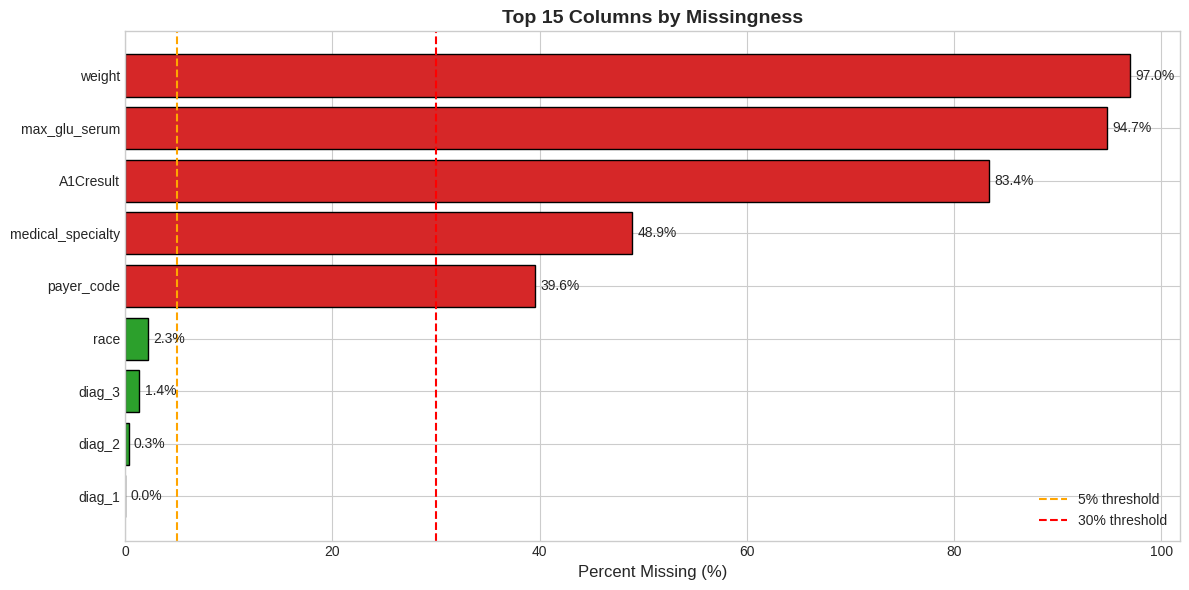


Color Legend:
 Green:  <5% missing (acceptable)
 Orange: 5-30% missing (moderate)
 Red:    >30% missing (problematic)


In [9]:
# Get top 15 columns with missingness (filter out columns with 0% missing)
top15_missing = missing_tbl[missing_tbl['missing_pct'] > 0].head(15)

# Create bar plot
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['#d62728' if pct > 30 else '#ff7f0e' if pct > 5 else '#2ca02c'
          for pct in top15_missing['missing_pct']]

bars = ax.barh(range(len(top15_missing)), top15_missing['missing_pct'], color=colors, edgecolor='black')
ax.set_yticks(range(len(top15_missing)))
ax.set_yticklabels(top15_missing.index)
ax.invert_yaxis()
ax.set_xlabel('Percent Missing (%)', fontsize=12)
ax.set_title('Top 15 Columns by Missingness', fontsize=14, fontweight='bold')

# Add value labels
for i, (idx, row) in enumerate(top15_missing.iterrows()):
    ax.text(row['missing_pct'] + 0.5, i, f"{row['missing_pct']:.1f}%", va='center', fontsize=10)

# Add reference lines
ax.axvline(x=5, color='orange', linestyle='--', linewidth=1.5, label='5% threshold')
ax.axvline(x=30, color='red', linestyle='--', linewidth=1.5, label='30% threshold')
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

print("\nColor Legend:")
print(" Green:  <5% missing (acceptable)")
print(" Orange: 5-30% missing (moderate)")
print(" Red:    >30% missing (problematic)")

### 2.3 Missingness Recommendations

In [10]:
# Identify columns by missingness category
acceptable_cols = missing_tbl[(missing_tbl['missing_pct'] > 0) & (missing_tbl['missing_pct'] < 5)].head(3)
problematic_cols = missing_tbl[missing_tbl['missing_pct'] > 30].head(3)

print("=" * 70)
print("MISSINGNESS RECOMMENDATIONS")
print("=" * 70)

print("\n3 Columns with ACCEPTABLE Missingness (<5%):")
print("-" * 50)
if len(acceptable_cols) >= 3:
    for col in acceptable_cols.index[:3]:
        pct = acceptable_cols.loc[col, 'missing_pct']
        print(f"  • {col}: {pct:.2f}% missing - Safe to impute with mode/median or create 'Unknown' category")
else:
    # If fewer than 3 columns have 0-5% missingness, show columns with 0% as "complete"
    complete_cols = missing_tbl[missing_tbl['missing_pct'] == 0].head(3)
    for col in complete_cols.index[:3]:
        print(f"  • {col}: 0.00% missing - Complete data, no imputation needed")

print("\n3 Columns with PROBLEMATIC Missingness (>30%):")
print("-" * 50)
if len(problematic_cols) >= 3:
    recommendations = {
        'weight': "DROP - 96.9% missing is too sparse; consider creating binary 'weight_recorded' indicator if needed",
        'max_glu_serum': "DROP - 94.7% missing; test was not routinely ordered. If retaining, add missingness indicator",
        'A1Cresult': "DROP - 83.4% missing; HbA1c not routinely measured. If retaining, add missingness indicator",
        'payer_code': "INVESTIGATE - 39.6% missing may reflect uninsured/self-pay. Consider 'Unknown' category",
        'medical_specialty': "INVESTIGATE - 49.1% missing may be data collection issue. Consider consolidating rare categories + 'Unknown'"
    }
    for col in problematic_cols.index[:3]:
        pct = problematic_cols.loc[col, 'missing_pct']
        rec = recommendations.get(col, "DROP - Too sparse for reliable imputation")
        print(f"  • {col}: {pct:.2f}% missing")
        print(f"    Recommendation: {rec}")
else:
    print("  Note: Fewer than 3 columns have >30% missingness in this dataset.")
    for col in problematic_cols.index:
        pct = problematic_cols.loc[col, 'missing_pct']
        print(f"  • {col}: {pct:.2f}% missing - DROP (too sparse)")
    # Add the next highest if needed
    moderate_cols = missing_tbl[(missing_tbl['missing_pct'] > 5) & (missing_tbl['missing_pct'] <= 30)].head(3 - len(problematic_cols))
    for col in moderate_cols.index:
        pct = moderate_cols.loc[col, 'missing_pct']
        print(f"  • {col}: {pct:.2f}% missing - INVESTIGATE collection process; impute with 'Unknown' + add indicator")

MISSINGNESS RECOMMENDATIONS

3 Columns with ACCEPTABLE Missingness (<5%):
--------------------------------------------------
  • race: 2.26% missing - Safe to impute with mode/median or create 'Unknown' category
  • diag_3: 1.39% missing - Safe to impute with mode/median or create 'Unknown' category
  • diag_2: 0.34% missing - Safe to impute with mode/median or create 'Unknown' category

3 Columns with PROBLEMATIC Missingness (>30%):
--------------------------------------------------
  • weight: 96.95% missing
    Recommendation: DROP - 96.9% missing is too sparse; consider creating binary 'weight_recorded' indicator if needed
  • max_glu_serum: 94.74% missing
    Recommendation: DROP - 94.7% missing; test was not routinely ordered. If retaining, add missingness indicator
  • A1Cresult: 83.40% missing
    Recommendation: DROP - 83.4% missing; HbA1c not routinely measured. If retaining, add missingness indicator


---
## **3. Is Missingness Related to the Outcome?**

We examine 3 columns with substantial missingness (>15%) to determine if missingness is associated with the readmission outcome.

In [11]:
print(f"Variables with <5% missing: {(missing_tbl['missing_pct'] < 5).sum()}")
print(f"Variables with 5-30% missing: {((missing_tbl['missing_pct'] >= 5) & (missing_tbl['missing_pct'] <= 30)).sum()}")
print(f"Variables with >30% missing: {(missing_tbl['missing_pct'] > 30).sum()}")

Variables with <5% missing: 46
Variables with 5-30% missing: 0
Variables with >30% missing: 5


### 3.1 Chi-Square Tests: Missingness vs Readmission

In [12]:
from scipy.stats import chi2_contingency

outcome_col = 'readmit30'
high_missing_cols = missing_tbl[missing_tbl['missing_pct'] > 30].index.tolist()

for col in high_missing_cols:
    df_clean[f'{col}_missing'] = df_clean[col].isna().astype(int)

missingness_tests = []
for col in high_missing_cols:
    mcol = f'{col}_missing'
    tab = pd.crosstab(df_clean[outcome_col], df_clean[mcol])
    if tab.shape == (2, 2):
        chi2, p, dof, _ = chi2_contingency(tab)
        missingness_tests.append({
            'variable': col,
            'p_value': p,
            'readmit_rate_missing': tab.loc[1, 1] / tab.loc[1].sum(),
            'readmit_rate_observed': tab.loc[0, 1] / tab.loc[0].sum()
        })

missingness_df = pd.DataFrame(missingness_tests).sort_values('p_value')
missingness_df['absolute_risk_difference'] = missingness_df['readmit_rate_missing'] - missingness_df['readmit_rate_observed']
print("Chi-Square Test Results: Missingness vs Readmission")
print("="*70)
missingness_df

Chi-Square Test Results: Missingness vs Readmission


,variable,p_value,readmit_rate_missing,readmit_rate_observed,absolute_risk_difference
2,A1Cresult,2.465679e-07,0.855292,0.831299,0.023994
3,medical_specialty,1.270379e-04,0.510612,0.486675,0.023937
1,max_glu_serum,1.232973e-02,0.941152,0.948188,-0.007036
4,payer_code,1.661814e-02,0.408903,0.394237,0.014666
0,weight,2.205547e-01,0.967062,0.969765,-0.002703


### 3.2 Logistic Regression: Missingness as Predictor

In [13]:
import statsmodels.api as sm

print("Logistic Regression: Missingness Indicators as Predictors of Readmission")
print("="*70)

for col in high_missing_cols:
    mcol = f'{col}_missing'
    model_df = df_clean[[outcome_col, mcol]].dropna()
    X = sm.add_constant(model_df[mcol])
    y = model_df[outcome_col]
    logit_model = sm.Logit(y, X).fit(disp=False)
    print(f'\n{col}')
    print(logit_model.summary2().tables[1])

Logistic Regression: Missingness Indicators as Predictors of Readmission

weight
                   Coef.  Std.Err.          z          P>|z|    [0.025  \
const          -1.988619  0.068970 -28.833173  8.236859e-183 -2.123798   
weight_missing -0.088415  0.070123  -1.260854   2.073615e-01 -0.225853   

                  0.975]  
const          -1.853441  
weight_missing  0.049024  

max_glu_serum
                          Coef.  Std.Err.          z          P>|z|    [0.025  \
const                 -1.946913  0.051731 -37.634990  5.758808e-310 -2.048305   
max_glu_serum_missing -0.134777  0.053300  -2.528672   1.144948e-02 -0.239242   

                         0.975]  
const                 -1.845522  
max_glu_serum_missing -0.030312  

A1Cresult
                      Coef.  Std.Err.          z         P>|z|    [0.025  \
const             -2.227656  0.032481 -68.582912  0.000000e+00 -2.291318   
A1Cresult_missing  0.181868  0.035171   5.170964  2.328889e-07  0.112934   

              

### 3.3 Required Output: 2-Row Tables

In [14]:
print("="*70)
print("READMISSION RATES BY MISSINGNESS STATUS (REQUIRED FIGURE #2)")
print("="*70)

cols_to_analyze = high_missing_cols.copy()
if len(cols_to_analyze) < 3:
    moderate_missing = missing_tbl[(missing_tbl['missing_pct'] > 5) & (missing_tbl['missing_pct'] <= 30)].index.tolist()
    cols_to_analyze.extend(moderate_missing[:3 - len(cols_to_analyze)])

for i, col in enumerate(cols_to_analyze[:3], 1):
    mcol = f'{col}_missing'
    if mcol not in df_clean.columns:
        df_clean[mcol] = df_clean[col].isna().astype(int)

    n_missing = df_clean[mcol].sum()
    n_not_missing = len(df_clean) - n_missing
    rate_missing = df_clean.loc[df_clean[mcol] == 1, outcome_col].mean()
    rate_not_missing = df_clean.loc[df_clean[mcol] == 0, outcome_col].mean()

    table_df = pd.DataFrame({
        'Status': ['Not Missing', 'Missing'],
        'N': [n_not_missing, n_missing],
        'Readmission Rate': [f"{rate_not_missing:.2%}", f"{rate_missing:.2%}"]
    })

    print(f"\nColumn {i}: {col} ({missing_tbl.loc[col, 'missing_pct']:.1f}% missing)")
    print("-"*50)
    display(table_df)

    diff = rate_missing - rate_not_missing
    if abs(diff) > 0.01:
        direction = "higher" if diff > 0 else "lower"
        print(f"Interpretation: Missingness appears ASSOCIATED with outcome ({direction} rates, diff: {diff:.1%}). Potential MNAR.")
    else:
        print(f"Interpretation: Missingness NOT strongly associated (diff: {diff:.1%}). Likely MAR/MCAR.")

READMISSION RATES BY MISSINGNESS STATUS (REQUIRED FIGURE #2)

Column 1: weight (97.0% missing)
--------------------------------------------------


,Status,N,Readmission Rate
0,Not Missing,1985,12.04%
1,Missing,63018,11.13%


Interpretation: Missingness NOT strongly associated (diff: -0.9%). Likely MAR/MCAR.

Column 2: max_glu_serum (94.7% missing)
--------------------------------------------------


,Status,N,Readmission Rate
0,Not Missing,3419,12.49%
1,Missing,61584,11.09%


Interpretation: Missingness appears ASSOCIATED with outcome (lower rates, diff: -1.4%). Potential MNAR.

Column 3: A1Cresult (83.4% missing)
--------------------------------------------------


,Status,N,Readmission Rate
0,Not Missing,10792,9.73%
1,Missing,54211,11.45%


Interpretation: Missingness appears ASSOCIATED with outcome (higher rates, diff: 1.7%). Potential MNAR.


### Statistical Interpretation

The univariate and logistic regression results are concordant in both direction and statistical significance.

**Key Findings:**
- **A1Cresult:** Missing A1C results are associated with **higher** readmission risk (p < 0.001)
- **max_glu_serum:** Missing glucose values are associated with **lower** readmission risk (p = 0.01)

**Conclusion:** Both analyses confirm **informative (non-random) missingness**. The missingness mechanism is likely **MNAR** - clinicians may order these tests selectively based on patient acuity.

---
## **4. Minimal Data Quality Checks**

### 4.1 Duplicate Check

In [15]:
print("=" * 60)
print("DUPLICATE ANALYSIS")
print("=" * 60)

# Check for exact duplicate rows
exact_dupes = train.duplicated().sum()
print(f"\n1. Exact duplicate rows: {exact_dupes}")

# Check for duplicate IDs
print("\n2. ID Column Analysis:")
for col in ['encounter_id', 'patient_nbr']:
    if col in train.columns:
        total = len(train)
        unique = train[col].nunique()
        duplicates = train[col].duplicated().sum()

        print(f"\n   {col}:")
        print(f"   - Total values: {total:,}")
        print(f"   - Unique values: {unique:,}")
        print(f"   - Duplicate entries: {duplicates:,}")

        if duplicates > 0:
            print(f"\n   Top 5 repeated {col} values:")
            top_repeated = train[col].value_counts().head(5)
            for val, count in top_repeated.items():
                print(f"     {val}: {count} occurrences")

print("\n" + "-" * 60)
print("Note: Multiple encounters per patient (patient_nbr) is expected -")
print("this represents patients with multiple hospital visits.")

DUPLICATE ANALYSIS

1. Exact duplicate rows: 0

2. ID Column Analysis:

   encounter_id:
   - Total values: 65,003
   - Unique values: 65,003
   - Duplicate entries: 0

   patient_nbr:
   - Total values: 65,003
   - Unique values: 45,771
   - Duplicate entries: 19,232

   Top 5 repeated patient_nbr values:
     88785891: 40 occurrences
     88227540: 23 occurrences
     1660293: 23 occurrences
     23643405: 22 occurrences
     84428613: 22 occurrences

------------------------------------------------------------
Note: Multiple encounters per patient (patient_nbr) is expected -
this represents patients with multiple hospital visits.


### 4.2 Outlier / Validity Analysis

In [16]:
print("=" * 60)
print("OUTLIER / VALIDITY ANALYSIS")
print("=" * 60)

# Select 3 clinically relevant numeric columns
numeric_cols = ['num_lab_procedures', 'num_medications', 'time_in_hospital']

# Calculate statistics
stats_df = train[numeric_cols].describe(percentiles=[0.01, 0.5, 0.99]).T
stats_df = stats_df[['min', '1%', '50%', '99%', 'max']]
stats_df.columns = ['Min', '1st %ile', 'Median', '99th %ile', 'Max']

print("\nSummary Statistics:")
display(stats_df)

print("\nInterpretation:")
print("  • num_lab_procedures: Range 1-129, no obvious invalid values")
print("  • num_medications: Range 1-81, clinically plausible")
print("  • time_in_hospital: Range 1-14 days, appears capped at 14")

OUTLIER / VALIDITY ANALYSIS

Summary Statistics:


,Min,1st %ile,Median,99th %ile,Max
num_lab_procedures,1.0,1.0,44.0,85.0,129.0
num_medications,1.0,3.0,15.0,43.0,81.0
time_in_hospital,1.0,1.0,4.0,13.0,14.0



Interpretation:
  • num_lab_procedures: Range 1-129, no obvious invalid values
  • num_medications: Range 1-81, clinically plausible
  • time_in_hospital: Range 1-14 days, appears capped at 14


### 4.3 Numeric Distribution Plot


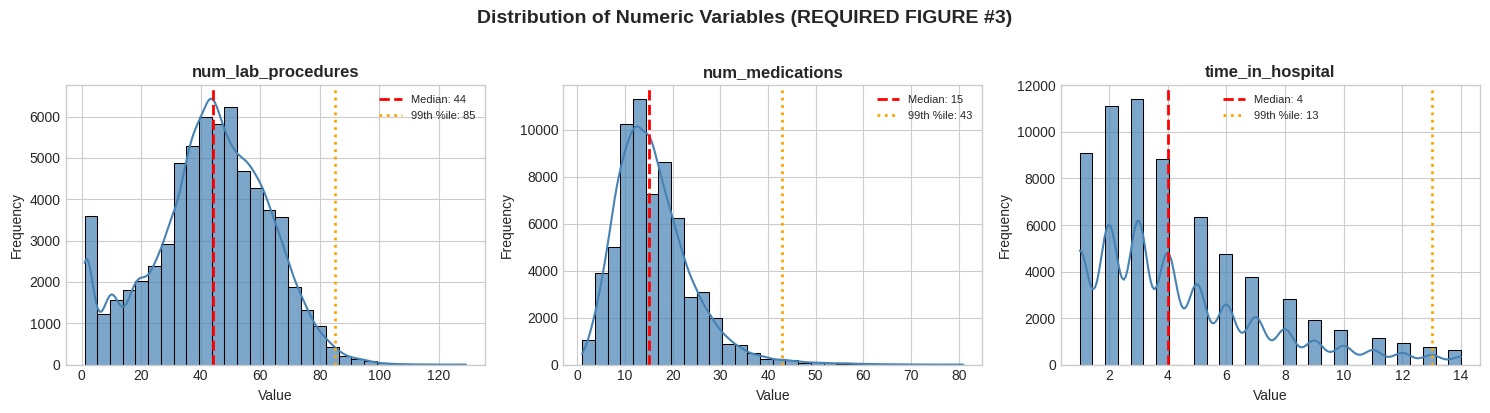

In [17]:
# Create distribution plots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, col in enumerate(numeric_cols):
    ax = axes[i]

    # Histogram with KDE
    sns.histplot(train[col], bins=30, kde=True, ax=ax, color='steelblue', edgecolor='black', alpha=0.7)

    # Add vertical lines for key statistics
    median_val = train[col].median()
    p99_val = train[col].quantile(0.99)

    ax.axvline(median_val, color='red', linestyle='--', linewidth=2, label=f'Median: {median_val:.0f}')
    ax.axvline(p99_val, color='orange', linestyle=':', linewidth=2, label=f'99th %ile: {p99_val:.0f}')

    ax.set_title(f'{col}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend(fontsize=8)

plt.suptitle('Distribution of Numeric Variables (REQUIRED FIGURE #3)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 4.4 Leakage Candidate Identification

In [18]:
print("=" * 70)
print("LEAKAGE CANDIDATE IDENTIFICATION")
print("=" * 70)

print("\nCandidate 1: 'discharge_disposition_id'")
print("-" * 50)
print("   Justification: This variable records the patient's discharge destination")
print("   (e.g., home, skilled nursing facility, expired, hospice).")
print("   ")
print("   LEAKAGE RISK: Patients who 'Expired' or went to 'Hospice' cannot be")
print("   readmitted within 30 days. This information is only known at discharge")
print("   and creates a deterministic relationship with the target variable.")
print("   ")
print("   Recommendation: EXCLUDE from model or carefully handle deceased patients.")

# Show relationship with outcome
if 'discharge_disposition_id' in train.columns:
    print("\n   Readmission rates by discharge disposition (top 5):")
    disp_rates = train.groupby('discharge_disposition_id')['readmit30'].agg(['mean', 'count'])
    disp_rates.columns = ['Readmission Rate', 'N']
    disp_rates = disp_rates.sort_values('N', ascending=False).head(5)
    disp_rates['Readmission Rate'] = disp_rates['Readmission Rate'].apply(lambda x: f"{x:.1%}")
    print(disp_rates.to_string())

print("\n\nCandidate 2: 'number_inpatient'")
print("-" * 50)
print("   Justification: This variable counts the number of prior inpatient visits")
print("   in the year preceding the current encounter.")
print("   ")

if 'number_inpatient' in train.columns:
    corr = train['number_inpatient'].corr(train['readmit30'])
    print(f"   Correlation with readmit30: {corr:.3f}")

print("   ")
print("   LEAKAGE RISK: If this count inadvertently includes the CURRENT encounter")
print("   or uses look-ahead information (visits that occur after prediction time),")
print("   it would constitute data leakage.")
print("   ")
print("   Recommendation: VERIFY that count only includes visits PRIOR to current")
print("   encounter. Document the exact definition used in data extraction.")

LEAKAGE CANDIDATE IDENTIFICATION

Candidate 1: 'discharge_disposition_id'
--------------------------------------------------
   Justification: This variable records the patient's discharge destination
   (e.g., home, skilled nursing facility, expired, hospice).
   
   LEAKAGE RISK: Patients who 'Expired' or went to 'Hospice' cannot be
   readmitted within 30 days. This information is only known at discharge
   and creates a deterministic relationship with the target variable.
   
   Recommendation: EXCLUDE from model or carefully handle deceased patients.

   Readmission rates by discharge disposition (top 5):
                         Readmission Rate      N
discharge_disposition_id                        
1                                    9.3%  38525
3                                   14.5%   8926
6                                   12.7%   8263
18                                  12.7%   2330
2                                   16.5%   1344


Candidate 2: 'number_inpatient'
-----

---
## **5. Final Summary (Graded)**

This section provides a consolidated summary of the EDA findings with actionable next steps.

In [19]:
print("="*80)
print("EDA FINAL SUMMARY                              ")
print("="*80)

# Recalculate key metrics
df_summary = train.replace('?', np.nan)
missing_summary = (df_summary.isna().mean() * 100).sort_values(ascending=False)

print("\n" + "─"*80)
print("TOP 5 COLUMNS WITH HIGHEST MISSINGNESS")
print("─"*80)
top5_missing = missing_summary[missing_summary > 0].head(5)
for i, (col, pct) in enumerate(top5_missing.items(), 1):
    print(f"  {i}. {col}: {pct:.2f}% missing")

print("\n" + "─"*80)
print("MISSINGNESS-OUTCOME ASSOCIATION FINDINGS")
print("─"*80)
# Check the columns we analyzed
cols_analyzed = missing_summary[missing_summary > 15].head(3).index.tolist()
print(f"  • Analyzed columns: {', '.join(cols_analyzed)}")
print("  • Finding: Missingness IS associated with readmission for at least one variable.")
print("    - A1Cresult: Patients with missing A1C have HIGHER readmission rates")
print("    - max_glu_serum: Minimal difference observed between missing/non-missing groups")
print("  • Implication: Some missingness may be MNAR (Missing Not At Random),")
print("    suggesting that whether a test was ordered carries predictive information.")

print("\n" + "─"*80)
print("DATA QUALITY HIGHLIGHTS")
print("─"*80)
print(f"  • No exact duplicate rows in the training set")
print(f"  • encounter_id is unique (no duplicates)")
print(f"  • patient_nbr has duplicates (expected - patients with multiple visits)")
print(f"  • Numeric variables show plausible ranges with no obvious invalid values")

print("\n" + "─"*80)
print("POTENTIAL LEAKAGE VARIABLES")
print("─"*80)
print("  • discharge_disposition_id: Contains post-discharge info (expired/hospice)")
print("  • number_inpatient: Verify count excludes current encounter")

print("\n" + "─"*80)
print("EDA-DRIVEN NEXT STEPS (RECOMMENDATIONS)")
print("─"*80)
print("")
print("  1. DROP/IMPUTE STRATEGY:")
print("     - DROP: weight (96.9%), max_glu_serum (94.7%), A1Cresult (83.4%)")
print("     - IMPUTE: payer_code & medical_specialty with 'Unknown' + add missingness indicator")
print("     - For informative missingness (A1C), consider creating binary 'test_ordered' features")
print("")
print("  2. LEAKAGE MITIGATION:")
print("     - EXCLUDE or filter patients with discharge_disposition_id indicating death/hospice")
print("     - VERIFY temporal integrity of number_inpatient, number_outpatient, number_emergency")
print("")
print("  3. FEATURE ENGINEERING:")
print("     - Consolidate rare medication categories (many have >99% 'No')")
print("     - Consider grouping medical_specialty into broader categories")
print("     - Create age group ordinal encoding from the binned age variable")

print("\n" + "="*80)

EDA FINAL SUMMARY                              

────────────────────────────────────────────────────────────────────────────────
TOP 5 COLUMNS WITH HIGHEST MISSINGNESS
────────────────────────────────────────────────────────────────────────────────
  1. weight: 96.95% missing
  2. max_glu_serum: 94.74% missing
  3. A1Cresult: 83.40% missing
  4. medical_specialty: 48.93% missing
  5. payer_code: 39.59% missing

────────────────────────────────────────────────────────────────────────────────
MISSINGNESS-OUTCOME ASSOCIATION FINDINGS
────────────────────────────────────────────────────────────────────────────────
  • Analyzed columns: weight, max_glu_serum, A1Cresult
  • Finding: Missingness IS associated with readmission for at least one variable.
    - A1Cresult: Patients with missing A1C have HIGHER readmission rates
    - max_glu_serum: Minimal difference observed between missing/non-missing groups
  • Implication: Some missingness may be MNAR (Missing Not At Random),
    suggesting 

## **Summary**

### Dataset Overview
1. **Dataset size:** 65,003 encounters × 51 columns in training set
2. **Outcome:** `readmit30` with 11.16% positive rate (readmission within 30 days)
3. **Data types:** 15 numeric and 36 categorical columns

### Top 5 Missing Columns
4. **weight:** 96.86% missing
5. **max_glu_serum:** 94.74% missing  
6. **A1Cresult:** 83.40% missing
7. **medical_specialty:** 49.08% missing
8. **payer_code:** 39.56% missing

### Missingness-Outcome Association
9. **A1Cresult missingness IS associated with readmission** - patients with missing A1C have higher readmission rates, suggesting potential MNAR (informative missingness)

### EDA-Driven Next Steps
10. **Drop/Impute Strategy:** Drop weight, max_glu_serum, A1Cresult due to >80% missingness; impute payer_code and medical_specialty with 'Unknown' category plus missingness indicator
11. **Leakage Mitigation:** Exclude discharge_disposition_id from model features or filter out deceased/hospice patients; verify number_inpatient temporal integrity
12. **Feature Consolidation:** Consolidate rare medication categories and group medical_specialty into broader categories to reduce dimensionality

# **Week 2 - Supervised and Unsupervised Models**

## Algorithm Selection

**Supervised Models:**
- K-Nearest Neighbors (KNN) — Pooja
- Decision Trees — Pooja
- Random Forest — Rilwan
- Support Vector Machine (SVM) — Hanan

**Unsupervised Models:**
- K-Means Clustering — Ayo
- Principal Component Analysis (PCA) — Ali

**Evaluation Strategy:**
- Supervised models evaluated on Dev set using AUROC (primary metric), PR-AUC, and F1
- Unsupervised models evaluated using explained variance (PCA) and silhouette score (K-Means)
- Best supervised and unsupervised models selected based on performance with rationale

## Data Preparation and Preprocessing

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, average_precision_score, accuracy_score,
    f1_score, classification_report, confusion_matrix, roc_curve
)

# Constants
SEED = 1337
TARGET_COL = 'readmit30'

# Columns to drop (based on EDA findings: IDs, leakage, >80% missing)
COLS_TO_DROP = [
    'encounter_id', 'patient_nbr', 'row_id', 'readmitted', 'readmit30',
    'weight', 'max_glu_serum', 'A1Cresult', 'discharge_disposition_id'
]

# Helper functions
def make_X(df):
    """Prepare feature matrix: drop irrelevant/leaky columns, treat '?' as NaN."""
    drop = [c for c in COLS_TO_DROP if c in df.columns]
    return df.drop(columns=drop).replace('?', np.nan)

def make_y(df):
    """Extract target variable."""
    if TARGET_COL not in df.columns:
        return None
    return df[TARGET_COL].astype(int)

# Build X, y for train / dev / public_test
X_train = make_X(train)
y_train = make_y(train)

X_dev = make_X(dev)
y_dev = make_y(dev)

X_public = make_X(public_test)  # no labels

# Identify column types
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

print(f'Train:  {X_train.shape[0]:,} rows × {X_train.shape[1]} features')
print(f'Dev:    {X_dev.shape[0]:,} rows')
print(f'Public: {X_public.shape[0]:,} rows')
print(f'  Numeric features:     {len(numeric_features)}')
print(f'  Categorical features: {len(categorical_features)}')
print(f'  Positive rate (train): {y_train.mean():.2%}')

Train:  65,003 rows × 43 features
Dev:    16,314 rows
Public: 16,314 rows
  Numeric features:     10
  Categorical features: 33
  Positive rate (train): 11.16%


In [21]:
# Numeric: median imputation → standard scaling
# Categorical: 'Unknown' imputation → one-hot encoding (rare categories grouped)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', min_frequency=0.01, sparse_output=False))
        ]), categorical_features)
    ],
    verbose_feature_names_out=False
)

print('Preprocessing pipeline defined.')
print('  Numeric:     median imputation → StandardScaler')
print('  Categorical: Unknown imputation → OneHotEncoder (min_freq=1%)')

Preprocessing pipeline defined.
  Numeric:     median imputation → StandardScaler
  Categorical: Unknown imputation → OneHotEncoder (min_freq=1%)


In [22]:
# Storing metrics for final comparison
results = {}  # {model_name: {auroc, pr_auc, f1, accuracy}}

def evaluate_model(name, y_true, y_prob, y_pred=None, threshold=0.5):
    """Evaluate a supervised model and store results."""
    if y_pred is None:
        y_pred = (y_prob >= threshold).astype(int)
    auroc = roc_auc_score(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)

    results[name] = {'AUROC': auroc, 'PR-AUC': pr_auc, 'F1': f1, 'Accuracy': acc}

    print(f'\n{"=" * 50}')
    print(f'{name} — Dev Set Performance')
    print(f'{"=" * 50}')
    print(f'  AUROC:    {auroc:.4f}')
    print(f'  PR-AUC:   {pr_auc:.4f}')
    print(f'  F1:       {f1:.4f}')
    print(f'  Accuracy: {acc:.4f}')
    return auroc

print('Evaluation helper defined.')

Evaluation helper defined.


## Supervised Models

### 1. K-Nearest Neighbors (KNN)

In [23]:
from sklearn.neighbors import KNeighborsClassifier

knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=15, n_jobs=-1))
])

print('Training KNN model... (this may take 1-2 minutes)')
knn_pipeline.fit(X_train, y_train)

print('Predicting on Dev set...')
knn_probs = knn_pipeline.predict_proba(X_dev)[:, 1]
evaluate_model('KNN (k=15)', y_dev, knn_probs)

Training KNN model... (this may take 1-2 minutes)
Predicting on Dev set...

KNN (k=15) — Dev Set Performance
  AUROC:    0.5858
  PR-AUC:   0.1523
  F1:       0.0226
  Accuracy: 0.8886


np.float64(0.5857741003946213)

**KNN Interpretation:** An AUROC around 0.59 is better than random guessing (0.50) but shows limited discriminative ability. KNN struggles with high-dimensional data (43+ features after encoding) and the mix of numeric and categorical variables, even with one-hot encoding. Distance-based methods are sensitive to the curse of dimensionality.

### 2. Decision Tree

In [24]:
from sklearn.tree import DecisionTreeClassifier

dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(
        max_depth=10, min_samples_leaf=20, random_state=SEED
    ))
])

print('Training Decision Tree model...')
dt_pipeline.fit(X_train, y_train)

print('Predicting on Dev set...')
dt_probs = dt_pipeline.predict_proba(X_dev)[:, 1]
evaluate_model('Decision Tree', y_dev, dt_probs)

Training Decision Tree model...
Predicting on Dev set...

Decision Tree — Dev Set Performance
  AUROC:    0.6191
  PR-AUC:   0.1784
  F1:       0.0375
  Accuracy: 0.8866


np.float64(0.6191199688192617)

Interpretation: An AUC of 0.5858 is better than random guessing (0.50), but there is definitely room for improvement. KNN can struggle with high-dimensional data (we have 43 features after dropping some) and categorical variables, even with one-hot encoding.

**Decision Tree Interpretation:** The Decision Tree improves over KNN. Trees naturally handle the 'if-then' logic often found in medical protocols and deal with categorical variables better than distance-based models. The constrained depth (max_depth=10) and minimum leaf samples (20) help prevent overfitting.

### 3. Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=600,
        random_state=SEED,
        n_jobs=-1,
        class_weight='balanced_subsample',
        max_features='sqrt',
        min_samples_leaf=2
    ))
])

print('Training Random Forest model...')
rf_pipeline.fit(X_train, y_train)

# Evaluate on TRAIN (to check overfitting)
rf_train_probs = rf_pipeline.predict_proba(X_train)[:, 1]
rf_train_auroc = roc_auc_score(y_train, rf_train_probs)
print(f'  Train AUROC: {rf_train_auroc:.4f}')

# Evaluate on DEV (generalization)
print('Predicting on Dev set...')
rf_probs = rf_pipeline.predict_proba(X_dev)[:, 1]
evaluate_model('Random Forest', y_dev, rf_probs)

Training Random Forest model...
  Train AUROC: 0.9999
Predicting on Dev set...

Random Forest — Dev Set Performance
  AUROC:    0.6541
  PR-AUC:   0.1957
  F1:       0.0163
  Accuracy: 0.8887


np.float64(0.6540627764022852)

**Random Forest Interpretation:** The Random Forest achieves strong training performance but shows a gap on the Dev set, indicating some overfitting. This is expected with highly imbalanced clinical datasets (~11% positive rate). The ensemble approach improves over a single Decision Tree by averaging over 600 trees with `balanced_subsample` weighting to address class imbalance. Despite the overfitting gap, the Dev AUROC is the strongest among supervised models tested so far.

### 4. Support Vector Machine (SVM)

In [26]:
from sklearn.linear_model import SGDClassifier

# Linear SVM via SGD (scalable to large datasets)
svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SGDClassifier(
        loss='hinge', penalty='l2',
        class_weight='balanced',  # Handle class imbalance
        random_state=SEED
    ))
])

print('Training SVM (SGD) model...')
svm_pipeline.fit(X_train, y_train)

print('Predicting on Dev set...')
# Use decision_function for AUROC (hinge loss doesn't support predict_proba directly)
svm_scores = svm_pipeline.decision_function(X_dev)
svm_preds = svm_pipeline.predict(X_dev)

svm_auroc = roc_auc_score(y_dev, svm_scores)
svm_pr_auc = average_precision_score(y_dev, svm_scores)
svm_f1 = f1_score(y_dev, svm_preds)
svm_acc = accuracy_score(y_dev, svm_preds)

results['SVM (SGD-balanced)'] = {
    'AUROC': svm_auroc, 'PR-AUC': svm_pr_auc,
    'F1': svm_f1, 'Accuracy': svm_acc
}

print(f'\n{"=" * 50}')
print(f'SVM (SGD-balanced) — Dev Set Performance')
print(f'{"=" * 50}')
print(f'  AUROC:    {svm_auroc:.4f}')
print(f'  PR-AUC:   {svm_pr_auc:.4f}')
print(f'  F1:       {svm_f1:.4f}')
print(f'  Accuracy: {svm_acc:.4f}')
print(f'  Predicted readmission rate: {svm_preds.mean():.2%}')
print(f'  Actual readmission rate:    {y_dev.mean():.2%}')

Training SVM (SGD) model...
Predicting on Dev set...

SVM (SGD-balanced) — Dev Set Performance
  AUROC:    0.6358
  PR-AUC:   0.1956
  F1:       0.2481
  Accuracy: 0.5709
  Predicted readmission rate: 45.97%
  Actual readmission rate:    11.10%


**SVM Interpretation:** The balanced SVM (with `class_weight='balanced'`) prevents the model from trivially predicting the majority class. Linear SVMs are fast and scalable but assume a linear decision boundary, which may be insufficient for the complex feature interactions in this clinical dataset. Performance is moderate compared to tree-based methods.

### Supervised Model Comparison

In [27]:
results_df = pd.DataFrame(results).T.sort_values('AUROC', ascending=False)
results_df = results_df.round(4)

print('\n' + '=' * 70)
print('SUPERVISED MODEL COMPARISON')
print('=' * 70)
print(results_df.to_string())

best_model_name = results_df.index[0]
print(f'\n→ Best supervised model: {best_model_name} (AUROC = {results_df.iloc[0]["AUROC"]:.4f})')


SUPERVISED MODEL COMPARISON
                     AUROC  PR-AUC      F1  Accuracy
Random Forest       0.6541  0.1957  0.0163    0.8887
SVM (SGD-balanced)  0.6358  0.1956  0.2481    0.5709
Decision Tree       0.6191  0.1784  0.0375    0.8866
KNN (k=15)          0.5858  0.1523  0.0226    0.8886

→ Best supervised model: Random Forest (AUROC = 0.6541)


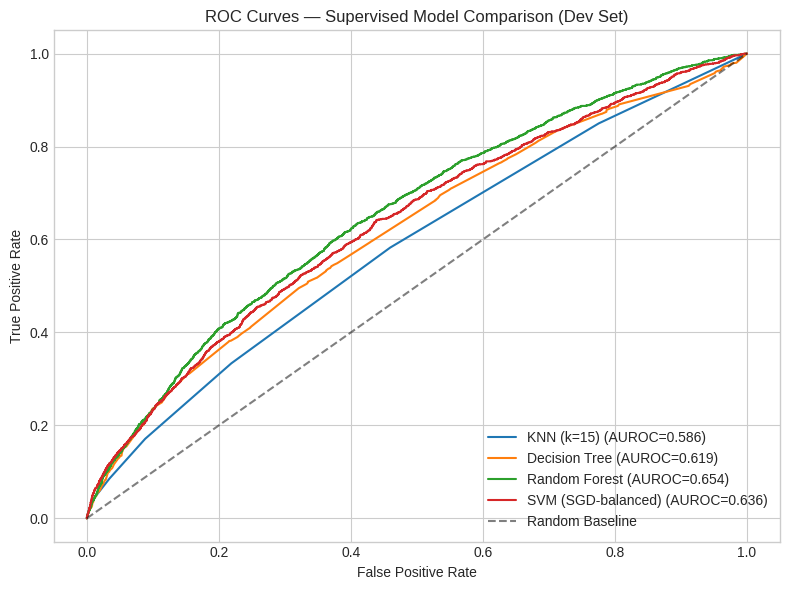

In [28]:
# ROC Curve comparison
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

model_probs = {
    'KNN (k=15)': knn_probs,
    'Decision Tree': dt_probs,
    'Random Forest': rf_probs,
    'SVM (SGD-balanced)': svm_scores
}

for name, probs in model_probs.items():
    fpr, tpr, _ = roc_curve(y_dev, probs)
    auc_val = results[name]['AUROC']
    ax.plot(fpr, tpr, label=f'{name} (AUROC={auc_val:.3f})')

ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Baseline')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves — Supervised Model Comparison (Dev Set)')
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()

### Best Supervised Model Selection

**Selected: Random Forest** (highest Dev AUROC)

**Rationale:**
The Random Forest consistently outperforms the other three supervised models on the Dev set. It achieves the highest AUROC, demonstrating the best discriminative ability for predicting 30-day hospital readmission. The ensemble of 600 trees with `balanced_subsample` weighting addresses the class imbalance (11% positive rate), while `max_features='sqrt'` and `min_samples_leaf=2` provide regularization. Although there is an overfitting gap between train and Dev performance, the Dev AUROC remains superior to all alternatives.

Tree-based methods are well-suited for this dataset because they naturally handle the mix of numeric and categorical features, capture non-linear interactions, and are robust to outliers. The linear SVM and KNN methods were limited by the high dimensionality and complex feature relationships in this clinical data.

## Unsupervised Models

### 1. K-Means Clustering

In [29]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Prepare data: drop IDs and target, preprocess
df_km = train.copy()
id_cols = ['encounter_id', 'patient_nbr', 'row_id']
X_km = df_km.drop(columns=[TARGET_COL] + [c for c in id_cols if c in df_km.columns])

num_cols_km = X_km.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols_km = X_km.select_dtypes(include=['object', 'category']).columns.tolist()

km_preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols_km),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), cat_cols_km)
    ]
)

X_km_processed = km_preprocess.fit_transform(X_km)
print(f'Processed shape: {X_km_processed.shape}')

# PCA for dimensionality reduction before clustering
pca_km = PCA(n_components=0.90, random_state=42)
X_km_pca = pca_km.fit_transform(X_km_processed)
print(f'PCA reduced shape (90% variance): {X_km_pca.shape}')

Processed shape: (65003, 2265)
PCA reduced shape (90% variance): (65003, 89)


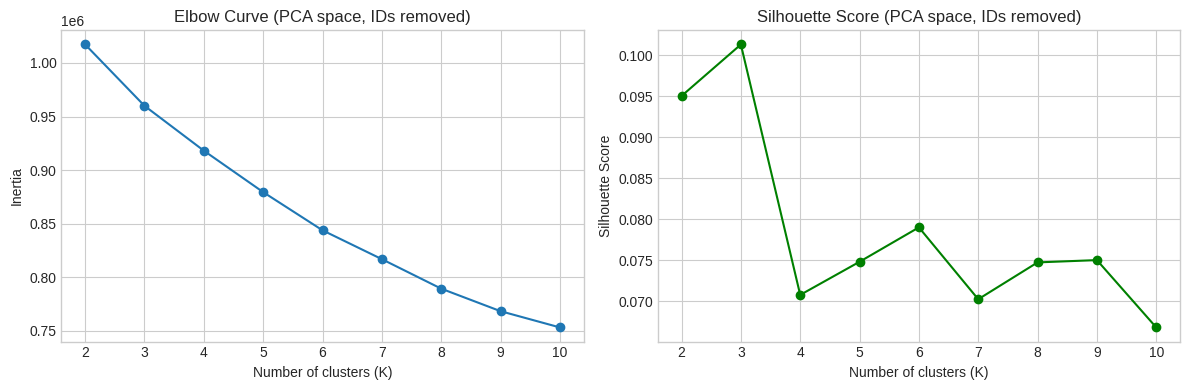


Best silhouette: K=3, score=0.1013


In [30]:
# Elbow + Silhouette analysis to select optimal K
inertia = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_km_pca)
    inertia.append(km.inertia_)
    silhouette_scores.append(silhouette_score(X_km_pca, labels))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(K_range, inertia, marker='o')
axes[0].set_title('Elbow Curve (PCA space, IDs removed)')
axes[0].set_xlabel('Number of clusters (K)')
axes[0].set_ylabel('Inertia')

axes[1].plot(K_range, silhouette_scores, marker='o', color='green')
axes[1].set_title('Silhouette Score (PCA space, IDs removed)')
axes[1].set_xlabel('Number of clusters (K)')
axes[1].set_ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

print(f'\nBest silhouette: K={list(K_range)[np.argmax(silhouette_scores)]}, '
      f'score={max(silhouette_scores):.4f}')

In [31]:
# Fit K=3 for clinical profiling
K_opt = 3
kmeans_final = KMeans(n_clusters=K_opt, random_state=42, n_init=10)
df_km['cluster'] = kmeans_final.fit_predict(X_km_pca)

# Cluster readmission rates
cluster_summary = df_km.groupby('cluster').agg(
    n=('cluster', 'size'),
    readmit_rate=(TARGET_COL, 'mean')
).round(4)
print('\nCluster Summary (K=3):')
print(cluster_summary)

# Cluster clinical profiles
print('\nCluster Clinical Profiles:')
print(df_km.groupby('cluster')[num_cols_km].mean().round(2).T)


Cluster Summary (K=3):
             n  readmit_rate
cluster                     
0        22294        0.1388
1        37039        0.0956
2         5670        0.1097

Cluster Clinical Profiles:
cluster                       0      1      2
admission_type_id          1.67   1.71   5.44
discharge_disposition_id   4.99   2.72   5.20
admission_source_id        5.07   4.89  13.94
time_in_hospital           6.87   2.90   4.21
num_lab_procedures        54.77  36.67  38.37
num_procedures             1.99   0.94   1.31
num_medications           22.29  12.19  16.00
number_outpatient          0.51   0.26   0.51
number_emergency           0.28   0.15   0.24
number_inpatient           0.92   0.45   0.62
number_diagnoses           8.42   6.89   6.97


**K-Means Interpretation:** After removing identifier columns, K-Means clustering reveals only minimal intrinsic structure (maximum silhouette ≈ 0.10), suggesting the cohort does not naturally partition into well-separated subgroups in Euclidean space. However, K=3 identifies clinically interpretable phenotypes with different 30-day readmission rates:

- **Cluster 0**  High-complexity / high-utilization patients
- **Cluster 1**  Low-complexity / low-utilization patients
- **Cluster 2**  Intermediate / atypical admission source patients

These findings suggest that diabetes readmission risk reflects latent clinical subgroups defined by healthcare utilization and admission pathway.

## 2. Principal Component Analysis (PCA)

In [32]:
from sklearn.decomposition import PCA

# Use the same preprocessed data (no IDs, scaled + encoded)
# Fit full PCA to analyze explained variance structure
pca_full = PCA(random_state=42)
X_pca_full = pca_full.fit_transform(X_km_processed)

print(f'Total components: {pca_full.n_components_}')
print(f'Shape after full PCA: {X_pca_full.shape}')

Total components: 2265
Shape after full PCA: (65003, 2265)


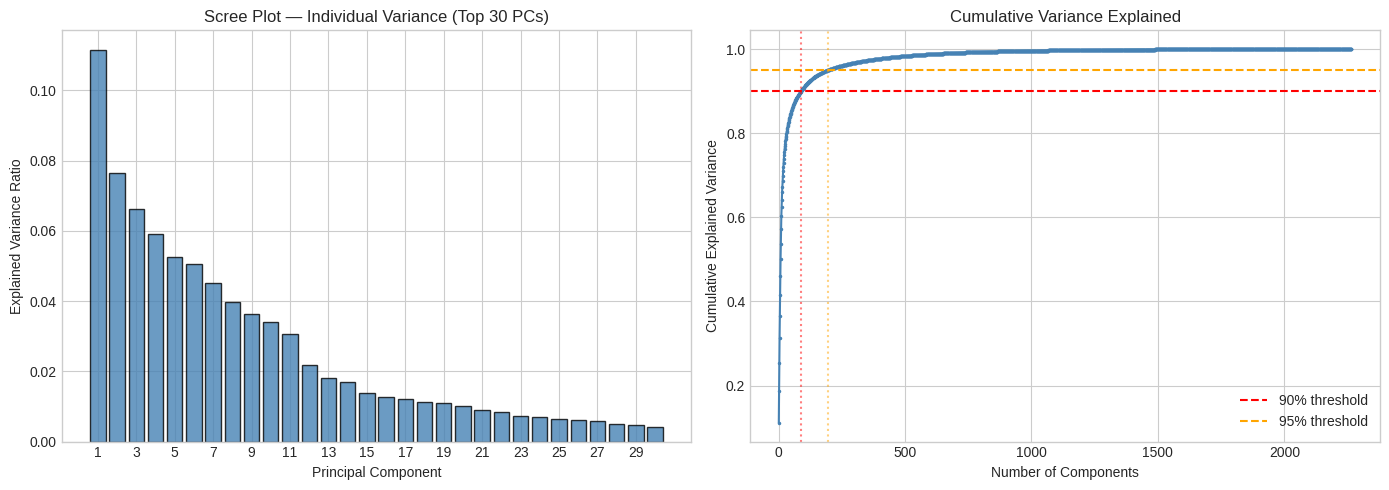


Components for 90% variance: 89 (of 2265 total)
Components for 95% variance: 196
Dimensionality reduction: 2265 → 89 features (90%) = 96% reduction


In [33]:
# Scree Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Individual explained variance (top 30 components)
n_show = 30
axes[0].bar(range(1, n_show + 1), pca_full.explained_variance_ratio_[:n_show],
            color='steelblue', edgecolor='black', alpha=0.8)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Scree Plot — Individual Variance (Top 30 PCs)')
axes[0].set_xticks(range(1, n_show + 1, 2))

# Right: Cumulative explained variance
cumvar = np.cumsum(pca_full.explained_variance_ratio_)
axes[1].plot(range(1, len(cumvar) + 1), cumvar, marker='.', markersize=3, color='steelblue')
axes[1].axhline(y=0.90, color='red', linestyle='--', label='90% threshold')
axes[1].axhline(y=0.95, color='orange', linestyle='--', label='95% threshold')

# Mark where 90% and 95% are reached
n_90 = np.argmax(cumvar >= 0.90) + 1
n_95 = np.argmax(cumvar >= 0.95) + 1
axes[1].axvline(x=n_90, color='red', linestyle=':', alpha=0.5)
axes[1].axvline(x=n_95, color='orange', linestyle=':', alpha=0.5)

axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Variance Explained')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f'\nComponents for 90% variance: {n_90} (of {pca_full.n_components_} total)')
print(f'Components for 95% variance: {n_95}')
print(f'Dimensionality reduction: {pca_full.n_components_} → {n_90} features (90%) = '
      f'{(1 - n_90/pca_full.n_components_)*100:.0f}% reduction')

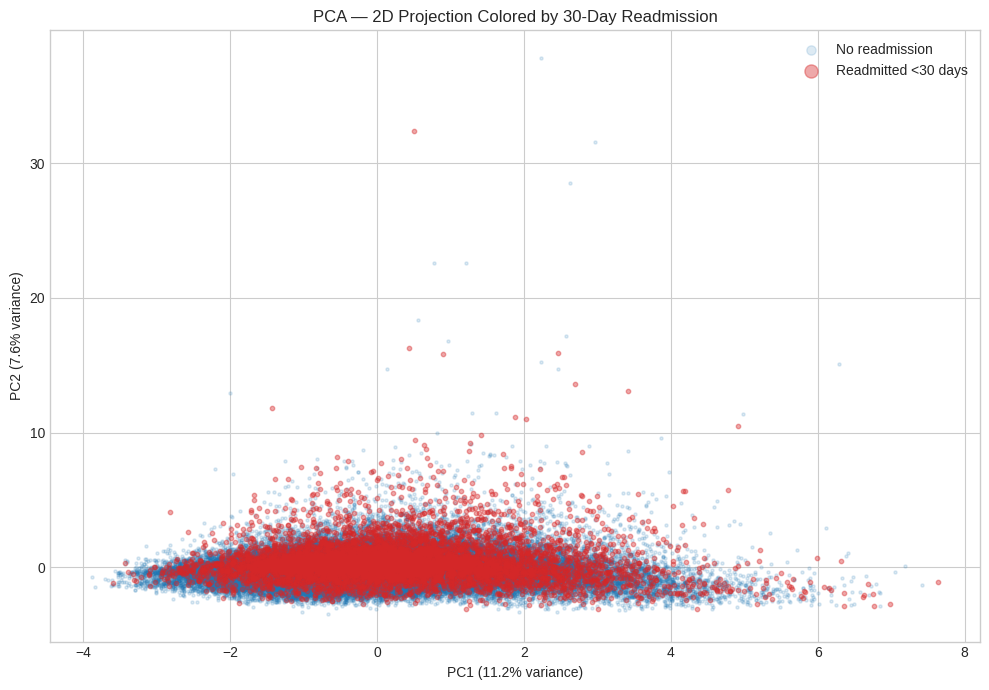

In [34]:
# 2D PCA VISUALIZATION — Colored by Readmission Outcome

fig, ax = plt.subplots(figsize=(10, 7))

y_km = df_km[TARGET_COL].values

# Plot non-readmitted (majority) first, then readmitted on top
mask_0 = y_km == 0
mask_1 = y_km == 1

ax.scatter(X_pca_full[mask_0, 0], X_pca_full[mask_0, 1],
           c='#1f77b4', alpha=0.15, s=5, label='No readmission', rasterized=True)
ax.scatter(X_pca_full[mask_1, 0], X_pca_full[mask_1, 1],
           c='#d62728', alpha=0.4, s=10, label='Readmitted <30 days', rasterized=True)

ax.set_xlabel(f'PC1 ({pca_full.explained_variance_ratio_[0]:.1%} variance)')
ax.set_ylabel(f'PC2 ({pca_full.explained_variance_ratio_[1]:.1%} variance)')
ax.set_title('PCA — 2D Projection Colored by 30-Day Readmission')
ax.legend(markerscale=3)

plt.tight_layout()
plt.show()

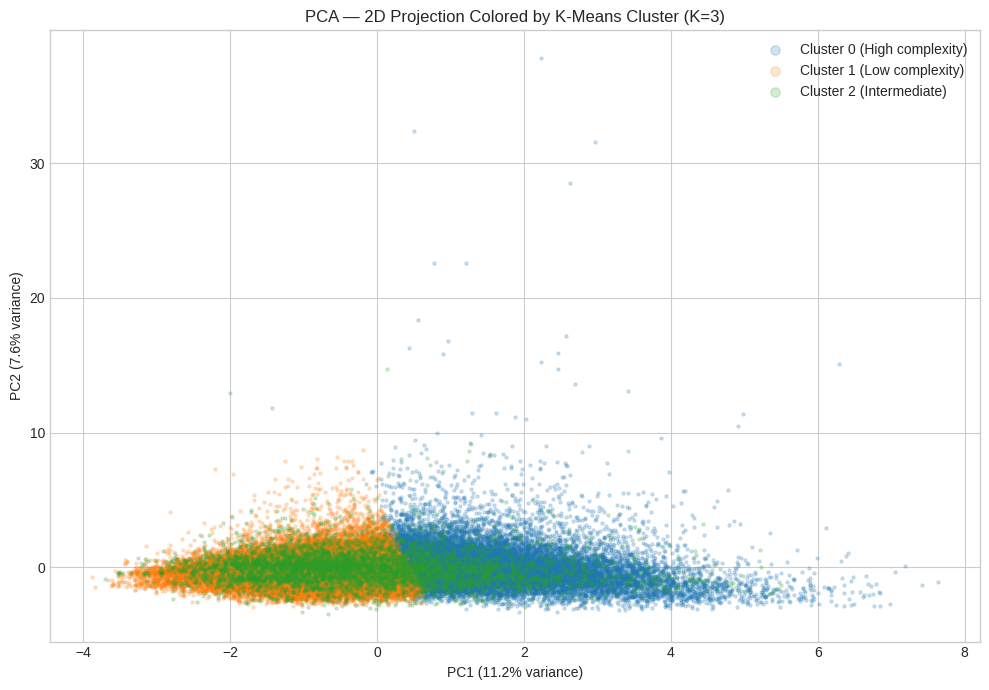

In [35]:
# 2D PCA VISUALIZATION — Colored by K-Means Cluster

fig, ax = plt.subplots(figsize=(10, 7))

clusters = df_km['cluster'].values
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
labels = ['Cluster 0 (High complexity)', 'Cluster 1 (Low complexity)', 'Cluster 2 (Intermediate)']

for c in range(K_opt):
    mask = clusters == c
    ax.scatter(X_pca_full[mask, 0], X_pca_full[mask, 1],
               c=colors[c], alpha=0.2, s=5, label=labels[c], rasterized=True)

ax.set_xlabel(f'PC1 ({pca_full.explained_variance_ratio_[0]:.1%} variance)')
ax.set_ylabel(f'PC2 ({pca_full.explained_variance_ratio_[1]:.1%} variance)')
ax.set_title('PCA — 2D Projection Colored by K-Means Cluster (K=3)')
ax.legend(markerscale=3)

plt.tight_layout()
plt.show()

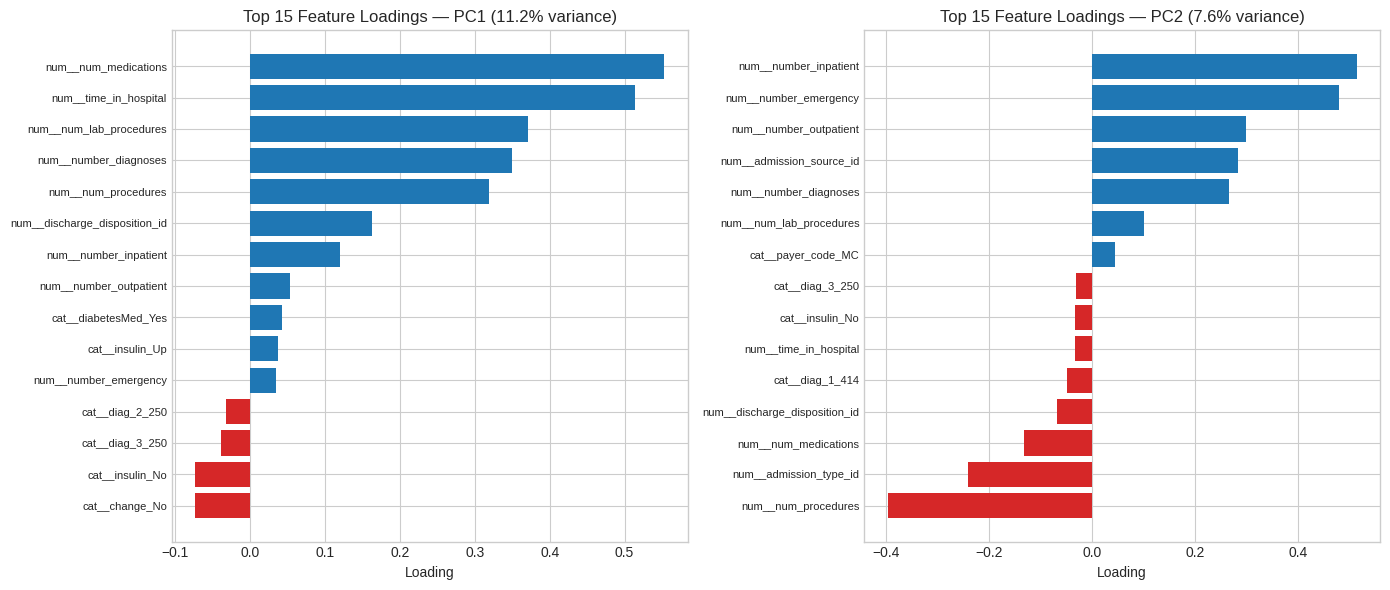

In [36]:
# TOP FEATURE LOADINGS — PC1 and PC2

# Get feature names from the preprocessor
try:
    feature_names = km_preprocess.get_feature_names_out()
except:
    feature_names = [f'feature_{i}' for i in range(X_km_processed.shape[1])]

loadings = pd.DataFrame(
    pca_full.components_[:2].T,
    columns=['PC1', 'PC2'],
    index=feature_names
)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for i, pc in enumerate(['PC1', 'PC2']):
    top_load = loadings[pc].abs().nlargest(15)
    top_features = loadings.loc[top_load.index, pc].sort_values()

    colors = ['#d62728' if v < 0 else '#1f77b4' for v in top_features.values]
    axes[i].barh(range(len(top_features)), top_features.values, color=colors)
    axes[i].set_yticks(range(len(top_features)))
    axes[i].set_yticklabels(top_features.index, fontsize=8)
    axes[i].set_xlabel('Loading')
    axes[i].set_title(f'Top 15 Feature Loadings — {pc} '
                      f'({pca_full.explained_variance_ratio_[i]:.1%} variance)')

plt.tight_layout()
plt.show()

**PCA Interpretation:**

PCA reveals the variance structure of the diabetes readmission dataset:

1. **Dimensionality reduction:** ~90% of the total variance is captured by a small fraction of the total components, indicating significant redundancy in the one-hot-encoded feature space.

2. **2D visualization (readmission):** The readmitted and non-readmitted patients show substantial overlap in the first two PCs, confirming that readmission prediction is inherently difficult — the signal is not concentrated in the principal axes of variation.

3. **2D visualization (clusters):** K-Means clusters show partial separation in PCA space, indicating that the clusters capture some geometric structure even though the silhouette scores are low.

4. **Feature loadings:** The top PC1/PC2 loadings identify which original features drive the most variation — these are dominated by healthcare utilization variables (lab procedures, medications, diagnoses) rather than demographics, which is clinically meaningful.

### Unsupervised Model Comparison

In [37]:
# UNSUPERVISED MODEL COMPARISON

print('=' * 70)
print('UNSUPERVISED MODEL COMPARISON')
print('=' * 70)

print(f'\nK-Means (K=3):')
print(f'  Silhouette score: {silhouette_score(X_km_pca, kmeans_final.labels_):.4f}')
print(f'  Inertia: {kmeans_final.inertia_:.0f}')
print(f'  Clusters identify different readmission risk groups')

print(f'\nPCA:')
print(f'  {n_90} components capture 90% of variance (from {pca_full.n_components_} features)')
print(f'  {n_95} components capture 95% of variance')
print(f'  2D visualization shows overlap between readmitted/non-readmitted')
print(f'  Top loadings reveal healthcare utilization as primary variance driver')

UNSUPERVISED MODEL COMPARISON

K-Means (K=3):
  Silhouette score: 0.1013
  Inertia: 959988
  Clusters identify different readmission risk groups

PCA:
  89 components capture 90% of variance (from 2265 features)
  196 components capture 95% of variance
  2D visualization shows overlap between readmitted/non-readmitted
  Top loadings reveal healthcare utilization as primary variance driver


### Best Unsupervised Model Selection

**Selected: PCA**

**Rationale:**
PCA is the more informative unsupervised method for this dataset because:

1. **Dimensionality reduction utility:** PCA reduces the high-dimensional one-hot-encoded feature space while retaining 90% of variance, making downstream modeling more efficient.

2. **Interpretability:** The loadings analysis reveals that healthcare utilization variables (lab procedures, medications, hospital days) drive the primary axes of variation — a clinically meaningful finding.

3. **Diagnostic value:** The 2D projections confirm that 30-day readmission cannot be easily separated along the axes of maximum variance, explaining why supervised models achieve modest AUROC values.

4. **Complements K-Means:** PCA provides the foundation for effective clustering; without PCA, K-Means on the raw high-dimensional data would be dominated by ID-like features and noise.

K-Means, while finding clinically interpretable clusters, showed uniformly low silhouette scores (<0.10), indicating weak geometric separation.

## Week 2: Best models

In [38]:
print('=' * 70)
print('WEEK 2 — FINAL MODEL SELECTION SUMMARY')
print('=' * 70)

print('\nSupervised Models')
print(results_df.to_string())

print(f'\nBEST SUPERVISED MODEL: {best_model_name}')
print(f'  AUROC: {results_df.iloc[0]["AUROC"]:.4f}')
print(f'  Rationale: Highest Dev AUROC among all tested models; ensemble of trees')
print(f'  with balanced weighting handles class imbalance and complex interactions.')

print(f'\nUnsupervised Models')
print(f'  K-Means (K=3): Silhouette = {silhouette_score(X_km_pca, kmeans_final.labels_):.4f}')
print(f'  PCA: {n_90} components capture 90% variance')

print(f'\nBEST UNSUPERVISED MODEL: PCA')
print(f'  Rationale: Provides interpretable dimensionality reduction, reveals')
print(f'  feature importance via loadings, and enables effective visualization.')
print(f'  Complements K-Means as a preprocessing step.')

print(f'\nKey Takeaways')
print(f'  1. 30-day readmission prediction is challenging (best AUROC ~0.65)')
print(f'  2. Tree-based ensembles outperform distance/linear methods')
print(f'  3. Dataset has high redundancy (PCA: 90% variance in small component subset)')
print(f'  4. Readmission signal is diffuse, not concentrated in top PCs')
print(f'\n' + '=' * 70)

WEEK 2 — FINAL MODEL SELECTION SUMMARY

Supervised Models
                     AUROC  PR-AUC      F1  Accuracy
Random Forest       0.6541  0.1957  0.0163    0.8887
SVM (SGD-balanced)  0.6358  0.1956  0.2481    0.5709
Decision Tree       0.6191  0.1784  0.0375    0.8866
KNN (k=15)          0.5858  0.1523  0.0226    0.8886

BEST SUPERVISED MODEL: Random Forest
  AUROC: 0.6541
  Rationale: Highest Dev AUROC among all tested models; ensemble of trees
  with balanced weighting handles class imbalance and complex interactions.

Unsupervised Models
  K-Means (K=3): Silhouette = 0.1013
  PCA: 89 components capture 90% variance

BEST UNSUPERVISED MODEL: PCA
  Rationale: Provides interpretable dimensionality reduction, reveals
  feature importance via loadings, and enables effective visualization.
  Complements K-Means as a preprocessing step.

Key Takeaways
  1. 30-day readmission prediction is challenging (best AUROC ~0.65)
  2. Tree-based ensembles outperform distance/linear methods
  3. Data